In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import tensorflow as tf

from pmdarima.arima import auto_arima, ADFTest

from nba_api.stats.endpoints import (playergamelog, leagueseasonmatchups, boxscoretraditionalv2,
                                     commonteamroster, teamgamelogs, leaguedashptteamdefend,
                                     teamestimatedmetrics)
from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll

import matplotlib.pyplot as plt

In [2]:
def fetch_players_id(players_full_name: str) -> int:
    """
    Get players ID given full name

    :param: players_full_name: player's full name
    :return: player's ID
    """
    try:
        players_id = players.find_players_by_full_name(players_full_name)[0]["id"]
    except IndexError:
        print(f"WARNING: {players_full_name} does not have a player ID!")
        players_id = None

    return players_id

def fetch_players_game_logs_df(players_id: str, season: str) -> pd.DataFrame:
    """
    Access the PlayerGameLog module to fetch the game logs df of given player

    :param players_id: player ID
    :return: the given player's game logs in df format
    """
    players_game_log = playergamelog.PlayerGameLog(player_id=players_id, season=season,
                                                   season_type_all_star="Regular Season")
    players_game_logs_df = players_game_log.get_data_frames()[0]
    try:
        players_game_logs_df =  players_game_logs_df.iloc[:num_games+1, :]
    except:
        players_game_logs_df = players_game_logs_df

    return players_game_logs_df


class WindowGenerator:
    def __init__(self, input_width, label_width, shift, label_columns):
        # Work out the label column indices.
        self.label_columns = label_columns

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.window_size = input_width + shift
        self.shift = shift
    
    def split_window(self, df):
        x = []
        y = []
        n = len(df)
        
        # labels = df[self.label_columns].values
        for i in range(n - self.window_size + 1):
            y_ = df[i]
            y.append(y_)
            
        for i in range(n - self.window_size + 1):
            i += 1
            inputs = df.iloc[i:self.input_width+i]
            x.append(inputs.values)
        
        assert len(x) == len(y)

        return np.asarray(x), np.asarray(y)

In [3]:
# offset = 5
# w = WindowGenerator(input_width=offset, label_width=1, shift=1,
#                     label_columns=stat)

In [4]:
# X, Y = w.split_window(ts_data)
# n = len(ts_data)

# games_to_forecast = 8

# x_train, y_train = X[:-games_to_forecast], Y[:-games_to_forecast]
# x_test, y_test = X[-games_to_forecast:], Y[-games_to_forecast:]

In [5]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [6]:
# model = Sequential()
# model.add(Dense(300, activation="relu", input_shape=(offset, )))
# model.add(Dense(300, activation="relu", batch_size=13)) # Nash
# model.add(Dropout(0.15)) 
# model.add(Dense(300, activation="relu", batch_size=32, kernel_regularizer=regularizers.l2(1e-4))) # Shaq
# model.add(Dense(300, activation="relu", batch_size=24, kernel_regularizer=regularizers.l2(1e-4))) # Kobe
# model.add(Dropout(0.2))
# model.add(Dense(300, activation="relu", batch_size=41, kernel_regularizer=regularizers.l2(1e-4))) # Dirk
# model.add(Dense(1, activation="relu"))

# model.compile(loss="MSE", optimizer="Adam", metrics="mean_squared_error")

In [7]:
# model.fit(x_train, y_train, batch_size=16, epochs=100, 
#           verbose=0, validation_split=0.1,)

In [8]:
# y_pred = model.predict(x_test)

In [9]:
# x = np.arange(len(y_test))

# plt.figure(figsize=(8, 5))
# plt.plot(x, y_pred, color="red", marker="x", label="Pred")
# plt.scatter(x, y_test, color="blue", marker="o", label="Actual")
# plt.legend()
# plt.show()

In [10]:
metrics_col = ["TEAM_NAME", "TEAM_ID", "E_PACE", "E_DEF_RATING"]

metrics_23 = teamestimatedmetrics.TeamEstimatedMetrics(season="2022-23").get_data_frames()[0][metrics_col]
metrics_22 = teamestimatedmetrics.TeamEstimatedMetrics(season="2021-22").get_data_frames()[0][metrics_col]
metrics_21 = teamestimatedmetrics.TeamEstimatedMetrics(season="2020-21").get_data_frames()[0][metrics_col]

In [11]:
nba_teams = teams.get_teams()
static_team_info = pd.DataFrame(nba_teams)
all_teams_id = static_team_info["id"].values

In [12]:
id_abb_lut = dict(zip(static_team_info["abbreviation"], static_team_info["id"]))

In [13]:
# atl = teamgamelogs.TeamGameLogs(team_id_nullable=1610612737, season_nullable="2022-23").get_data_frames()[0]

In [75]:
# df = leaguedashptteamdefend.LeagueDashPtTeamDefend(
#                                               defense_category="3 Pointers",
#                                               per_mode_simple="PerGame",
#                                               season="2022-23",
#                                               season_type_all_star="Regular Season",
#                                               season_segment_nullable="Pre All-Star"
#                                               ).get_data_frames()[0]

In [15]:
def get_opp_id(matchup: str):
    matchup_split = matchup.split(" ")
    opp_abb = matchup_split[2]
    team_id = static_team_info[static_team_info["abbreviation"]==opp_abb]["id"].values[0]
    
    return team_id

In [38]:
def add_rest_days(players_game_logs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add rest days column

    :param players_game_logs_df: player's game logs df
    :return: player's game logs df w/ rest days
    """
    players_game_logs_df["GAME_DATE"] = players_game_logs_df["GAME_DATE"].apply(lambda x: x.split(" "))
    players_game_logs_df["GAME_DATE"] = players_game_logs_df["GAME_DATE"].apply(convert_to_timestamp)
    players_game_logs_df = players_game_logs_df.sort_values(by=["GAME_DATE"], ascending=False)
    players_game_logs_df["REST_DAYS"] = players_game_logs_df["GAME_DATE"].diff(periods=-1)
    players_game_logs_df = players_game_logs_df.iloc[:-1, :]
    players_game_logs_df.loc[:, "REST_DAYS"] = players_game_logs_df["REST_DAYS"].dt.days

    return players_game_logs_df

def add_home_away_columns(players_game_logs_df: pd.DataFrame) -> pd.DataFrame:
    """
    Add one_hot encoding home or away bool columns

    :param players_game_logs_df: player's game logs df
    :return: player's game logs df w/ home & away columns
    """
    players_game_logs_df.loc[:, ("HOME", "AWAY")] = tf.one_hot(players_game_logs_df["MATCHUP"].\
                                                    apply(detect_home_or_away_games), 2)

    return players_game_logs_df

def detect_home_or_away_games(game: str):
    """
    Detect if a game is on home court or away
    """
    return 1 if "@" in game else 0

def convert_to_timestamp(date_string: str) -> pd.Timestamp:
    """
    Convert a date in string format to pd.Timestamp format
    """
    months_dict = init_months_dict()
    date = pd.Timestamp(f"{date_string[2]}-{months_dict[date_string[0]]}-{date_string[1][:-1]}")

    return date

def init_months_dict() -> dict:
    """
    Create months dictionary
    """
    months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
    months_dict = dict(zip(months, range(1, 13)))

    return months_dict

In [103]:
def merge_defensive_stats(season: str, game_log: pd.DataFrame, defensive_stats: list) -> pd.DataFrame:
    """
    """
    all_star_date = f"20{season}-02-14"
    
    pre_asb_overall = game_log[game_log["GAME_DATE"] < all_star_date].merge(defensive_stats[0], on="TEAM_ID")
    pre_asb_3pt = pre_asb_overall[pre_asb_overall["GAME_DATE"] < all_star_date].merge(defensive_stats[1],
                                                                                      on="TEAM_ID")
    
    post_asb_overall = game_log[game_log["GAME_DATE"] >= all_star_date].merge(defensive_stats[2], on="TEAM_ID")
    post_asb_3pt = post_asb_overall[post_asb_overall["GAME_DATE"] >= all_star_date].merge(defensive_stats[3],
                                                                                          on="TEAM_ID")
    
    return pd.concat([pre_asb_3pt, post_asb_3pt]).merge(defensive_stats[4], on="TEAM_ID")

### 2023 Season

In [104]:
player = fetch_players_id("Devin Booker")
log_23 = fetch_players_game_logs_df(player, "2022-23")
log_23["TEAM_ID"] = log_23["MATCHUP"].apply(get_opp_id)
log_23 = add_rest_days(add_home_away_columns(log_23))

pre_teams_d_23 = pd.read_csv("defense_pre_ASB_23.csv", index_col=0)
post_teams_d_23 = pd.read_csv("defense_post_ASB_23.csv", index_col=0)

pre_teams_3pt_23 = pd.read_csv("pre_asb_3pt_23.csv", index_col=0)
post_teams_3pt_23 = pd.read_csv("post_asb_3pt_23.csv", index_col=0)

player_23 = merge_defensive_stats(season="23", game_log=log_23,
                                  defensive_stats=[pre_teams_d_23, post_teams_d_23,
                                                   pre_teams_3pt_23, post_teams_3pt_23,
                                                   metrics_23])

### 2022 Season

In [90]:
log_22 = fetch_players_game_logs_df(player, "2021-22")
log_22["TEAM_ID"] = log_22["MATCHUP"].apply(get_opp_id)
log_22 = add_rest_days(add_home_away_columns(log_22))
all_star_22 = "2022-02-14"

pre_teams_d_22 = pd.read_csv("defense_pre_ASB_22.csv", index_col=0)
post_teams_d_22 = pd.read_csv("defense_post_ASB_22.csv", index_col=0)

player_22 = merge_defensive_stats(season="22", game_log=log_22,
                                  defensive_stats=[pre_teams_d_22, post_teams_d_22, metrics_22])

### 2021 Season

In [91]:
log_21 = fetch_players_game_logs_df(player, "2020-21")
log_21["TEAM_ID"] = log_21["MATCHUP"].apply(get_opp_id)
log_21 = add_rest_days(add_home_away_columns(log_21))
all_star_21 = "2021-02-14"

pre_teams_d_21 = pd.read_csv("defense_pre_ASB_21.csv", index_col=0)
post_teams_d_21 = pd.read_csv("defense_post_ASB_21.csv", index_col=0)

player_21 = merge_defensive_stats(season="21", game_log=log_21,
                                  defensive_stats=[pre_teams_d_21, post_teams_d_21, metrics_21])

In [92]:
complete_log = pd.concat([player_21, player_22, player_23]).sort_values(by=["GAME_DATE"], ascending=False)

In [93]:
predictors = ["MIN", "FGA", "HOME", "AWAY", "REST_DAYS",
              "D_FGM", "D_FGA", "D_FG_PCT", "PCT_PLUSMINUS", "E_PACE", "E_DEF_RATING"]
label = ["FG_PCT"]

In [94]:
game_to_predict = 10

X, y = complete_log[predictors].astype(np.float32), complete_log[label].astype(np.float32)
xtrain, ytrain = X.iloc[game_to_predict+1:, :].values, y.iloc[game_to_predict+1:, :].values
xtest, ytest = X.iloc[:game_to_predict, :].values, y.iloc[:game_to_predict, :].values

In [95]:
model = Sequential()
model.add(Dense(77, activation="tanh", input_shape=(len(predictors), )))
model.add(Dense(100, activation="tanh", batch_size=24, kernel_regularizer=regularizers.l1(1e-3)))
model.add(Dropout(0.1)) 
model.add(Dense(100, activation="tanh", batch_size=24, kernel_regularizer=regularizers.l2(1e-3)))
model.add(Dropout(0.1))
model.add(Dense(1, activation="tanh"))

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(learning_rate=1e-4),
              metrics="mean_squared_error")

In [96]:
model.fit(xtrain, ytrain, batch_size=24, epochs=200, verbose=0, validation_split=0.15, )

In [97]:
forecasts = []

for x in xtest:
    ypred = model.predict(x.reshape(1, len(predictors)))
    forecasts.append(round(ypred[0][0], 3))

forecasts = np.asarray(forecasts)
print(f"Forecasts: {forecasts}")
print()
print(f"Actual: {ytest.reshape(-1, )}")

Forecasts: [0.432 0.5   0.417 0.491 0.46  0.499 0.483 0.465 0.429 0.51 ]

Actual: [0.25  0.429 0.571 0.45  0.444 0.368 0.5   0.625 0.688 0.643]


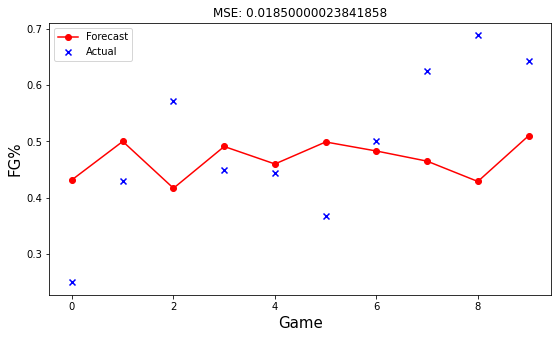

In [98]:
mse = round(np.mean((forecasts - ytest) ** 2), 4)

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(ytest)), forecasts, color="red", marker="o", label="Forecast")
plt.scatter(np.arange(len(ytest)), ytest.reshape(-1, ), color="blue", marker="x", label="Actual")
plt.xlabel("Game", fontsize=15)
plt.ylabel("FG%", fontsize=15)
plt.title(f"MSE: {mse}")
plt.legend()
plt.show()